In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds

using Gen
import GenPOMDPs
import GenParticleFilters
const GPF = GenParticleFilters

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


GenParticleFilters

In [2]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [3]:
### Initial model ###
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a)
    a == :up    ? [x, y + 1] :
    a == :down  ? [x, y - 1] : 
    a == :left  ? [x - 1, y] :
    a == :right ? [x + 1, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(prev, new)
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Observation model ###

@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    @assert !any(isinf.(zs))
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    @assert !any(isinf.(ỹ))

    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  

    @assert !any(any(isinf.(o)) for o in obs) "ỹ = $ỹ"
    
    return obs
end;

@load_generated_functions()

In [4]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#394"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [5]:
tr = generate(trajectory_model, (
        15,
        [
            :down, :down,
            :right, :right,
            :down, :down, :down, :down,
            :down, :right, :right, :right, :right,
            :down, :down, :right, :right
        ],
        PARAMS,
    ), choicemap((GenPOMDPs.state_addr(0, :pos), [5., 17.]))
)[1];

In [6]:
grid_args = nothing

In [83]:
_grid_args = (
    k = [9, 9], # grid dimensions for each var
    r = [.3, .3] # offsets [per gradation? total??]
)
@gen function grid_proposal_from_center(pos, t, obs_vector, params, grid_args, tau = 1.0, pmin = 1e-6)
    vs, ls = L.vector_grid(pos, grid_args...)
    poses = map(v -> L.Pose(v, params.orientation), vs)
    _segs = params.map; _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    
    log_ps, = L.eval_pose_vectors(
        Vector.(poses), obs_vector,
        _segs, params.obs.sensor_args...; sorted=false,
        fov=params.obs.fov, num_a=params.obs.n_rays
    );
    
    log_ps_tau = log_ps ./ tau
    probs      = L.normalize_exp(log_ps_tau)
    probs      = L.raise_probs(probs, pmin)

    # if any(isnan.(probs))
    #     println("pos = $pos ; poses = $poses ; obs = $obs_vector ; t = $t")
    #     println("vs = $vs")
    #     println("log_ps = $log_ps")
    # end

    # TODO: for some reason we are getting -Infs...is this expected behavior?
    probs = any(isnan.(probs)) ? [1/length(probs) for _ in probs] : probs
    j ~ categorical(probs)

    x′  = {:pos}  ~ mvuniform(vs[j][1:2] -  grid_args.r[1:2]/2, vs[j][1:2] + grid_args.r[1:2]/2)
    # hd′ = {:pose => :hd} ~   uniform(vs[j][3]   -  grid_args.r[3]  /2, vs[j][3]   + grid_args.r[3]  /2)

    # println("T = $t ; x = $pos ; x′ = $x′ ; grid_args = $grid_args")

    
    # try
    #     L.grid_index(pos, x′, grid_args..., linear=true)
    #     l = L.grid_index(x′, pos, grid_args..., linear=true)
    #     @assert l == j "l = $l ; j = $j ; vs[j] = $(vs[j]) ; "
    # catch e
    #     println("grid_args = $grid_args")
    #     println("grid cell: $(vs[j])")
    #     range = (vs[j][1:2] -  grid_args.r[1:2]/2, vs[j][1:2] + grid_args.r[1:2]/2)
    #     println("sampling range: $range")
    #     println("pos = $pos ; x` = $x′")

    #     error(e)
    # end


#     return Pose(x′, hd′), (j, vs, ls, log_ps)
    return j
end

@gen function grid_proposal(tr, grid_args)
    T, actions, params = get_args(tr)
    
    pos = tr[GenPOMDPs.state_addr(T, :pos)]
    obs = tr[GenPOMDPs.obs_addr(T)]

    re = {*} ~ grid_proposal_from_center(pos, T, obs, params, grid_args)
    
    return re
end

state_addr, obs_addr = GenPOMDPs.state_addr, GenPOMDPs.obs_addr
@transform involution (tr, aux) to (tr′, aux′) begin
    T, _, _ = get_args(tr)
    _, grid_args = get_args(aux)
    
    x′  = @read(aux[:pos] , :continuous)
    x  = @read(tr[state_addr(T, :pos)], :continuous)

    j = try
        L.grid_index(x, x′, grid_args..., linear=true)
    catch e
        # println("grid_args = $grid_args")
        # println("x = $x ; x' = $x′ ; grid = $(L.vector_grid(x′, grid_args...))")
        
        vals = []
        for t=0:T
            push!(vals, @read(tr[GenPOMDPs.state_addr(t, :pos)], :continuous))
        end

        println("T = $T ; vals = $vals")
        error(e)
    end
    
    @write(aux′[:j],   j, :discrete)
    @write(aux′[:pos],   x, :continuous)
    @write(tr′[GenPOMDPs.state_addr(T, :pos)],  x′, :continuous)
end


TraceTransformDSLProgram(var"#689###involution_fn!#2527", nothing)

In [100]:
N_ITERS=3

(pf_init, pf_step) = GenPOMDPs.pf(
    pomdp, PARAMS,
    (50,), # particles
    (); # bootstrap update
    pre_update = (state -> begin
        # for i=1:length(state.traces)
        #     tr = state.traces[i]
        #     tr2, accept = Gen.mh(tr, grid_proposal, (_grid_args,), involution)
        #     if accept
        #         state.traces[i] = tr
        #     end
        # end
        # GPF.pf_rejuvenate!(state, Gen.mh, (grid_proposal, (_grid_args,), involution), 1)
        GenPOMDPs.systematic_resample_if_ess_below_onefifth_particlecount(state)
        for i=1:N_ITERS
            GPF.pf_rejuvenate!(state, Gen.mh, (grid_proposal, (L.grid_schedule(_grid_args, i),), involution), 4)
        end
    end)
);

In [101]:
states = []
state = pf_init(GenPOMDPs.observation_sequence(tr)[1]);
push!(states, state)
for (a, obs) in zip(
        GenPOMDPs.action_sequence(tr)[2:end],
        GenPOMDPs.observation_sequence(tr)[2:end]
    )
    state = pf_step(state, a, obs)
    push!(states, state)
end
;

In [102]:
poses = [L.Pose(pos, PARAMS.orientation) for pos in GenPOMDPs.state_sequence(tr)]
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_vEnCZyxwD4.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_vEnCZyxwD4.gif")
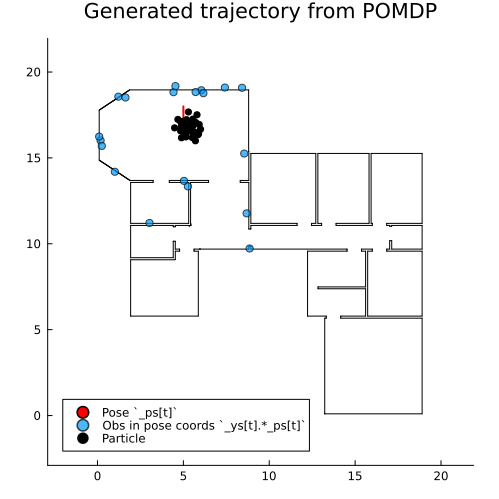

In [103]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=0:1:8
    p = poses[t + 1]
    y = ptclouds[t + 1]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    particles = states[t + 2]
    labeled=false
    for (w, tr) in zip(
            GenParticleFilters.get_norm_weights(particles),
            GenParticleFilters.get_traces(particles)
        )
        pos = tr[GenPOMDPs.state_addr(t)]
        if !labeled
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label="Particle")
            labeled=true
        else
            scatter!([pos], color=RGBA(0, 0, 0, sqrt(w)), label=nothing)
        end
    end
    
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

In [151]:
minimum(mvuniform([17.747370567968893, 12.363148741773339], [18.247370567968893, 12.863148741773339])[2] for _=1:10_000)

12.36319030980423

In [ ]:
I = [5, -2] ; k = [3, 3]
grid_args = (k = [3, 3], r = [0.25, 0.25])
x = [6.494659027373377, 13.592653030977333] ; x' = [5.697090080395847, 14.60199015949514] ; 
grid = (vs = [[5.447090080395847, 14.35199015949514] [5.447090080395847, 14.60199015949514] [5.447090080395847, 14.85199015949514]; [5.697090080395847, 14.35199015949514] [5.697090080395847, 14.60199015949514] [5.697090080395847, 14.85199015949514]; [5.947090080395847, 14.35199015949514] [5.947090080395847, 14.60199015949514] [5.947090080395847, 14.85199015949514]], linear_indices = [1 4 7; 2 5 8; 3 6 9])

In [41]:
shape = Tuple([3, 3])

(3, 3)

In [43]:
LinearIndices(shape)[2, 0]

BoundsError: BoundsError: attempt to access 3×3 LinearIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}} at index [2, 0]

In [51]:
pos = [7., 16.]
vs = L.vector_grid(pos, [3, 3], [1., 1.])[1]

3×3 Matrix{Vector{Float64}}:
 [6.0, 15.0]  [6.0, 16.0]  [6.0, 17.0]
 [7.0, 15.0]  [7.0, 16.0]  [7.0, 17.0]
 [8.0, 15.0]  [8.0, 16.0]  [8.0, 17.0]

In [54]:
[
    L.grid_index(val, pos, [3, 3], [1., 1.], linear=true)
    for val in vs
]

3×3 Matrix{Int64}:
 1  4  7
 2  5  8
 3  6  9

In [66]:
pos = [11.202166645314835, 15.75711002643013] ; 
poses = LineWorlds.Pose[LineWorlds.Pose([10.202166645314835, 14.75711002643013], 1.5707963267948966) LineWorlds.Pose([10.202166645314835, 15.75711002643013], 1.5707963267948966) LineWorlds.Pose([10.202166645314835, 16.75711002643013], 1.5707963267948966); LineWorlds.Pose([11.202166645314835, 14.75711002643013], 1.5707963267948966) LineWorlds.Pose([11.202166645314835, 15.75711002643013], 1.5707963267948966) LineWorlds.Pose([11.202166645314835, 16.75711002643013], 1.5707963267948966); LineWorlds.Pose([12.202166645314835, 14.75711002643013], 1.5707963267948966) LineWorlds.Pose([12.202166645314835, 15.75711002643013], 1.5707963267948966) LineWorlds.Pose([12.202166645314835, 16.75711002643013], 1.5707963267948966)] ; obs = [[100.09445017505114, -0.009568802944666948], [-6.144195539700633, -4.3043397954589295], [-1.9815811551515048, -3.4541056072732568], [-2.1068058219335595, -0.7871729878599241], [-1.9325435863106102, -0.3646079096369304], [-0.4917638530168624, -3.863343362690368], [-1.7857130221615751, -0.632583714561356], [-0.1678024297918534, -3.754078395392016], [1.3970346111569156, -3.5875476886938173], [3.108212837540828, -3.4896082126043115], [1.597008051994408, -3.900670169116124], [3.160958423657619, -3.9791633825661314], [0.46322369084909715, -3.8041471024344116], [1.8011421623378818, -3.610221568271649], [0.7577085292564959, -3.46649206959763], [3.1766942122325785, -2.105076257793844], [1.9896258243660019, -3.7893740190834557], [Inf, Inf], [3.444554309148634, -0.35571825461815243], [3.1217703913566073, -1.477827089139676], [3.489637386847114, 2.9807187307773932], [3.4868675281668744, 0.39234467297479025], [3.2187071232275843, -0.726431543086589], [3.3033731927339525, 0.12393523432432973], [3.0204331161363718, 2.29307477385327], [0.8778144028212731, 4.596515260763492], [3.013309361372807, 3.923030124615729], [0.46317652324177727, 4.922073586605617], [2.0415763575650168, 4.5763628353058605], [3.3005168495036776, 3.1147724281123104], [0.4387419433586629, 4.384359880359607], [-0.435434694373126, 4.715378522739648], [0.8389101014872723, 4.848177337973224], [-1.9726852086758253, 0.5240691459819554], [-1.9446781312509873, 3.8578292221731774], [-1.3144057675055754, 4.507084385991487], [100.00784628809328, 0.029792086737549767], [-4.289494907237328, 3.251289612256636], [100.10477830886163, -0.2781538901358583], [Inf, Inf]] ;
t = 1


1

In [ ]:
pos = [13.590346343655828, 13.167991594283162] ;
poses = LineWorlds.Pose[LineWorlds.Pose([12.590346343655828, 12.167991594283162], 1.5707963267948966) LineWorlds.Pose([12.590346343655828, 13.167991594283162], 1.5707963267948966) LineWorlds.Pose([12.590346343655828, 14.167991594283162], 1.5707963267948966); LineWorlds.Pose([13.590346343655828, 12.167991594283162], 1.5707963267948966) LineWorlds.Pose([13.590346343655828, 13.167991594283162], 1.5707963267948966) LineWorlds.Pose([13.590346343655828, 14.167991594283162], 1.5707963267948966); LineWorlds.Pose([14.590346343655828, 12.167991594283162], 1.5707963267948966) LineWorlds.Pose([14.590346343655828, 13.167991594283162], 1.5707963267948966) LineWorlds.Pose([14.590346343655828, 14.167991594283162], 1.5707963267948966)] ;
obs = [[100.04917510143031, -0.028062984710924607], [100.12019673418541, -0.28817717615102495], [-7.719163514559731, -3.7942025955363117], [-5.3098575585109815, -3.8418909577560854], [-1.3295080220985165, -3.955364915827255], [-0.3131444456160588, -3.8913439950014754], [-3.348150058914687, -0.6073282336537124], [0.8288198847811171, -3.4589570746769183], [-0.5167222898295012, -3.9112015850899073], [0.37467332469572034, -3.9623467642260524], [2.251400538198667, -3.722412726309896], [-1.2375887906537173, -3.866440856647253], [2.192366215076808, -2.3932330240284845], [1.9301273304018427, -0.34847227954582094], [1.711377694461622, -0.4283035859031932], [0.9098447787489863, -3.3839412605644954], [1.9840193472641645, -3.0361546896343534], [1.6767842272096822, -0.6901697131689634], [1.805355712125883, -0.8544597818601065], [2.2183461895332903, -2.360179843020587], [1.8750794248903884, -0.07785227726698961], [2.08935311562869, 2.519967617282613], [2.085153049937682, 1.6044439876081182], [2.017118491775327, -0.40310381893206876], [0.8566651460555138, 4.6786029363491615], [1.233480236530009, 4.8668800984286245], [2.00114207783693, 1.7865647141307626], [2.0436805807698777, 2.6997706554141696], [1.2767032101680833, 4.125110832405812], [1.8737179248097033, 3.051245507890202], [0.14194089465823995, 4.660587021212012], [0.8813353454396492, 4.7060428500549465], [-2.8121924619224985, 3.2579433189046743], [-3.379048732160781, 0.8674794500721785], [-0.7397088778286789, 4.808961376141081], [-3.4355313416535362, -0.2899654674100595], [100.24636800262653, 0.1931189772492519], [-2.6606524062789094, 3.932960562427342], [99.86360869634738, 0.0630138815467024], [-3.2073147932586705, 3.703405042557184]] ; t = 0
vs = [[12.590346343655828, 12.167991594283162] [12.590346343655828, 13.167991594283162] [12.590346343655828, 14.167991594283162]; [13.590346343655828, 12.167991594283162] [13.590346343655828, 13.167991594283162] [13.590346343655828, 14.167991594283162]; [14.590346343655828, 12.167991594283162] [14.590346343655828, 13.167991594283162] [14.590346343655828, 14.167991594283162]]
